In [6]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/PcmPy')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# make dataset

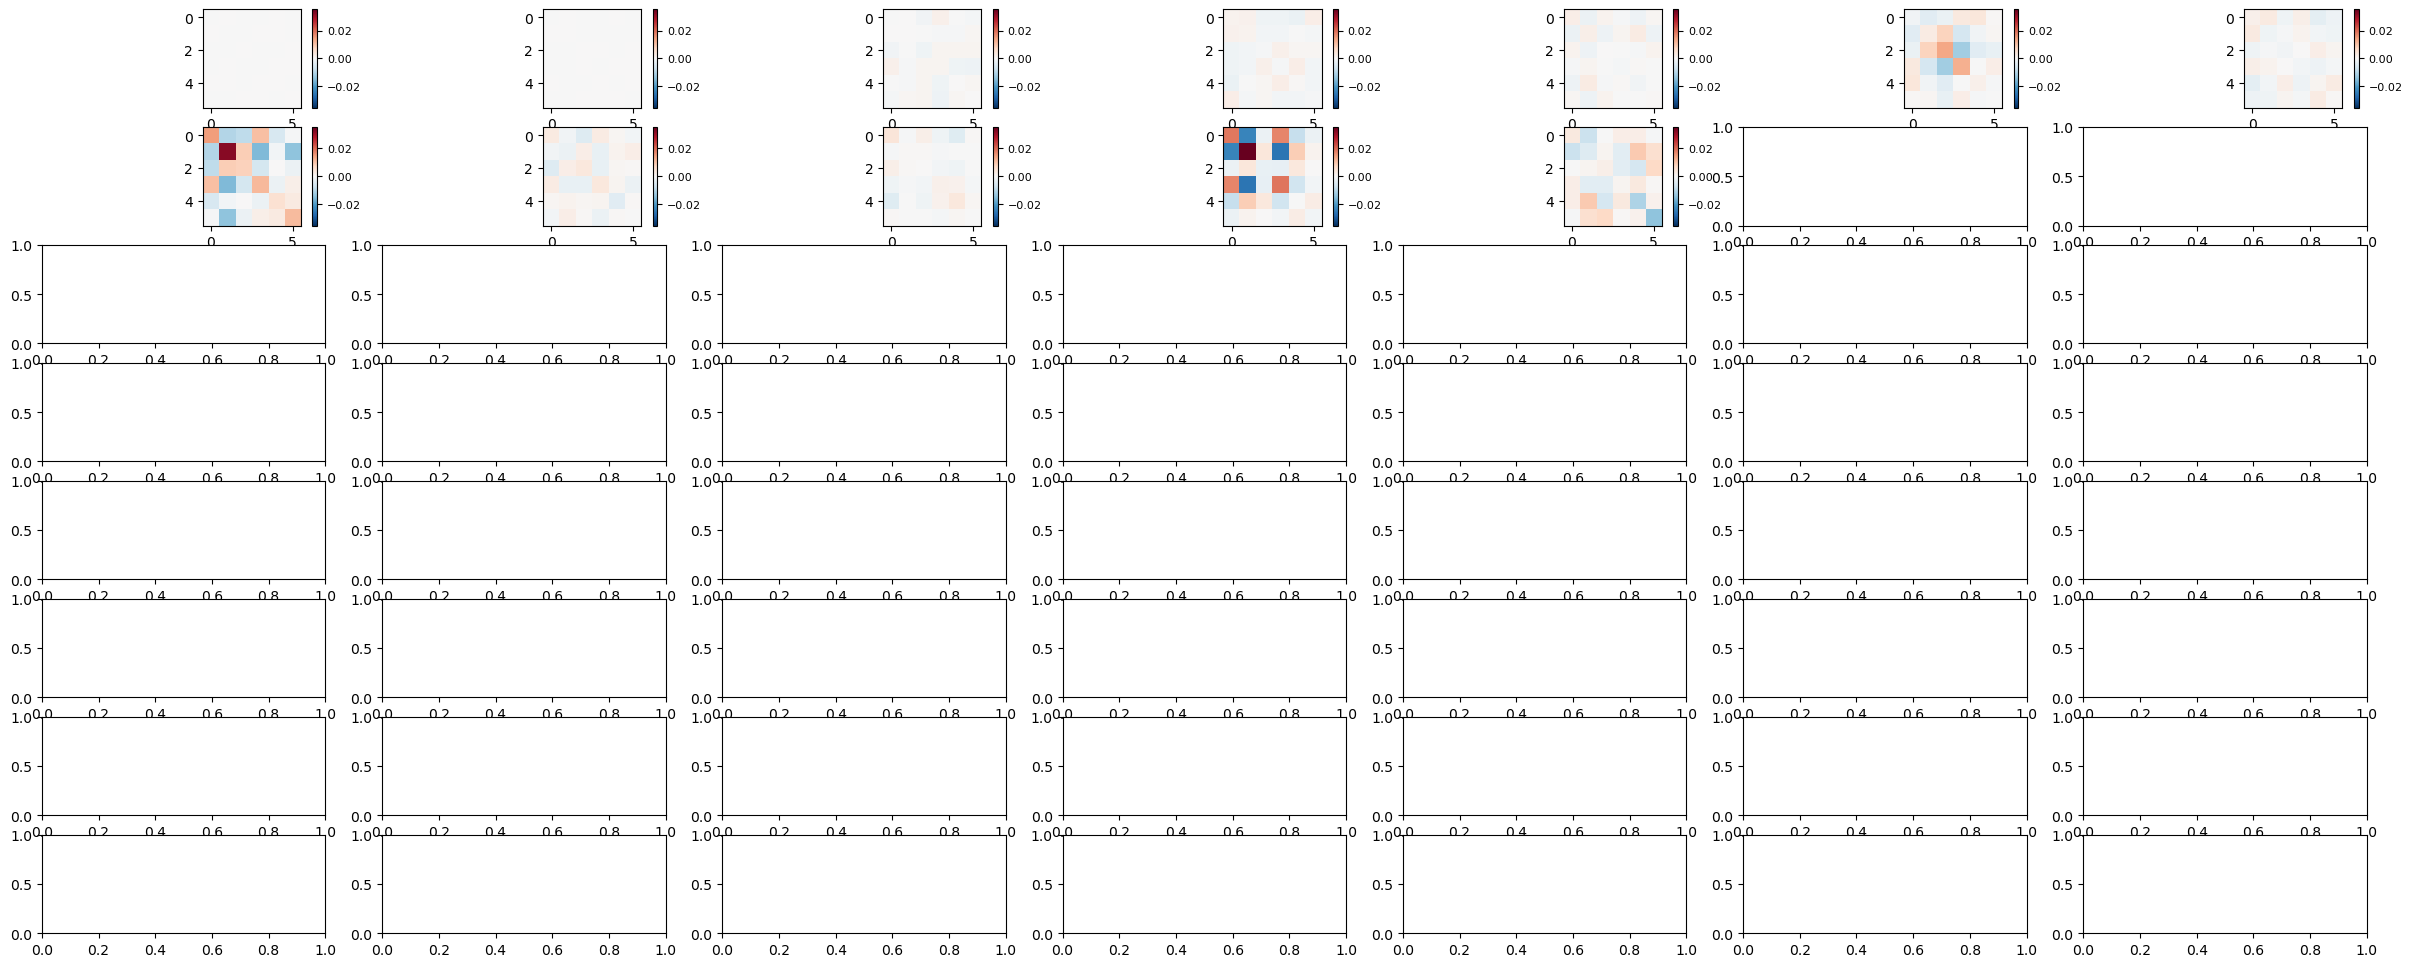

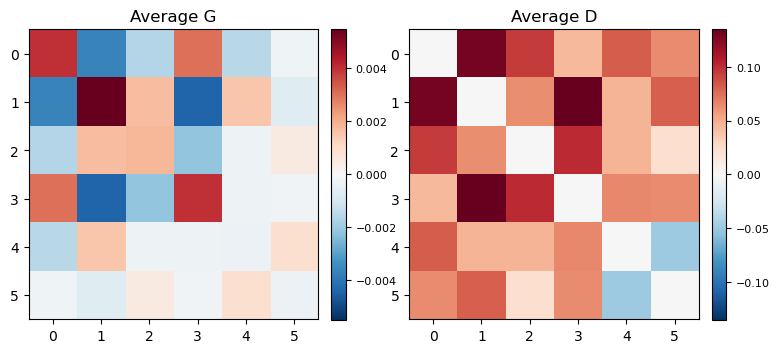

In [3]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r' 
sn_bad = [102, 103]

region = 'M1'

conditions = ['rhand']
rois = [f'{region}_L']
data, cond_vec, part_vec = [], [], []
for roi, condition in zip(rois, conditions):
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]
    
    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    cond_vec_tmp = d['cond_num_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]
    
    for i_sub in range(len(subject)):
        # Filter for the current condition
        if condition == 'lhand_marginal':
            Y = []
            subj_part = []
            subj_cond = []
            # loop on each direction
            for cond_num, direction in enumerate(labels):
                # in each partition:
                for k in range(1,11):
                    # bimanual trials that left hand goes in that direction:
                    tmp_name = f'bi:{direction}_'
                    idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                    idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                    idx = idx1 & idx2
                    y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                condition_name = f'lhand:{direction}'
                # find the condition numbers corresponding to this condition:
                idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

        if condition == 'rhand_marginal':
            Y = []
            subj_part = []
            subj_cond = []
            # loop on each direction
            for cond_num, direction in enumerate(labels):
                # in each partition:
                for k in range(1,11):
                    # bimanual trials that right hand goes in that direction:
                    tmp_name = f'_{direction}'
                    idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                    idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                    idx = idx1 & idx2
                    y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                condition_name = f'rhand:{direction}'
                # find the condition numbers corresponding to this condition:
                idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

        if condition == 'lhand' or condition == 'rhand':
            # Filter for the current condition
            idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
            Y = data_tmp[i_sub][idx, :]
            subj_cond = cond_vec_tmp[i_sub][idx]
            subj_part = part_tmp[i_sub][idx]

        data.append(Y)
        cond_vec.append(np.array(subj_cond))
        part_vec.append(subj_part)

Y = []
# --- RDM Calculation ---
for i_sub in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
    Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# show all second moment matrices
cmap = 'RdBu_r'
fig,ax = plt.subplots(8,7,figsize=(30,12))
vmax = np.abs(G_hat).max()
for i in range(N):
    ax[i//7,i%7].imshow(G_hat[i,:,:],vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i//7,i%7], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# avg:
fig, ax = plt.subplots(1,2,figsize=(9,4))
G_hat_avg = np.mean(G_hat, axis=0)
# G_hat_avg = G_hat_avg / np.trace(G_hat_avg)
vmax = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'Average G')

D_avg = pcm.G_to_dist(G_hat_avg)
D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
vmax = np.abs(D_avg).max()
ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'Average D')
plt.show() 



# Build models

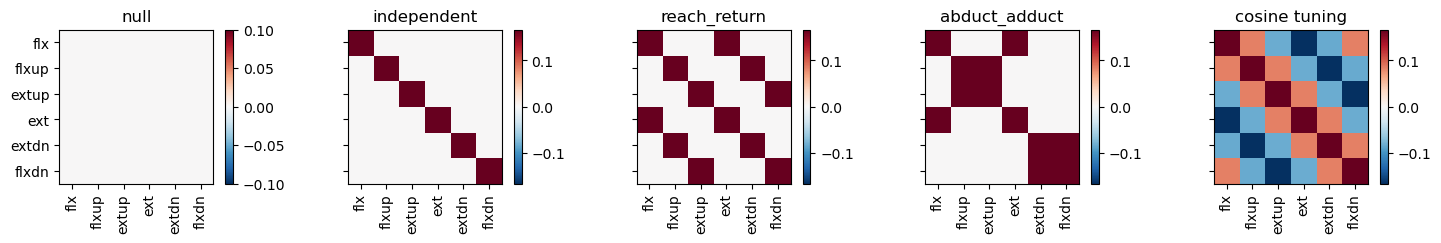

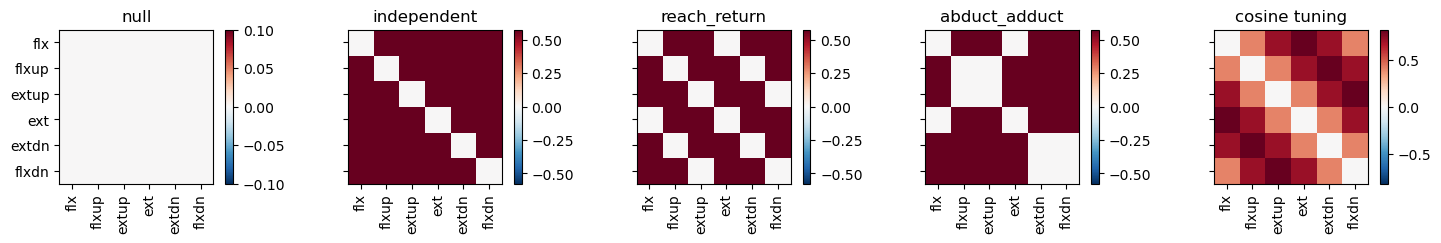

In [4]:
ncond = 6

M = []
modelG = {}

# Null model - no information:
cov = np.zeros((ncond, ncond))
M_null = pcm.FixedModel('null', cov)
M.append(M_null)

# indepdent model
cov = np.eye(ncond)
cov = cov/np.trace(np.eye(ncond))
# double center the model:
M_indep = pcm.FixedModel('independent', cov)
M.append(M_indep)

# reach and return model:
covs = np.tile(np.eye(ncond//2), (2,2))
covs = covs / np.trace(covs)
M_reach_return = pcm.FixedModel('reach_return', covs)
M.append(M_reach_return)
modelG['reach_return'] = [covs]

# Mirror Along vertical axis:
covs = np.eye(ncond)
covs[0,3] = 1
covs[1,2] = 1
covs[2,1] = 1
covs[3,0] = 1
covs[4,5] = 1
covs[5,4] = 1
covs = covs / np.trace(covs)
M_abduct_adduct = pcm.FixedModel('abduct_adduct', covs)
M.append(M_abduct_adduct)
modelG['abduct_adduct'] = [covs]

# Cosine tuning curve model:
angles_deg = np.array([0, 60, 120, 180, 240, 300], dtype=float)
delta = np.deg2rad(angles_deg[:, None] - angles_deg[None, :])
corr = np.cos(delta)        # Correlation: normalized to unit variance
corr = corr / np.trace(corr)
M_cosine = pcm.FixedModel('cosine tuning', corr)
M.append(M_cosine)
modelG['cosine tuning'] = [corr]

# Component model: reach_return + cosine:
M_rr_cos = pcm.ComponentModel('reach_return+cosine',[modelG['reach_return'][0],modelG['cosine tuning'][0]])
M.append(M_rr_cos)

# Component model: abduct_adduct + cosine:
M_abduct_adduct_cos = pcm.ComponentModel('abduct_adduct+cosine',[modelG['abduct_adduct'][0],modelG['cosine tuning'][0]])
M.append(M_abduct_adduct_cos)

# Component model: reach_return + abduct_adduct:
M_rr_abduct_adduct = pcm.ComponentModel('reach_return+abduct_adduct',[modelG['reach_return'][0],modelG['abduct_adduct'][0]])
M.append(M_rr_abduct_adduct)

# Component model: reach_return + abduct_adduct + cosine:
M_rr_abduct_adduct_cos = pcm.ComponentModel('reach_return+abduct_adduct+cosine',[modelG['reach_return'][0],modelG['abduct_adduct'][0],modelG['cosine tuning'][0]])
M.append(M_rr_abduct_adduct_cos)

# noise ceiling model:
M_ceil = pcm.FreeModel('ceil',ncond)
M.append(M_ceil)

nmodels = len(M)
fix, ax = plt.subplots(1,5, figsize=(18,2), sharey=True)
for i in range(5):
    vmin = -np.max(np.abs(M[i].G))
    vmax = np.max(np.abs(M[i].G))
    ax[i].imshow(M[i].G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks([0,1,2,3,4,5])
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks([0,1,2,3,4,5])
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(M[i].G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()

fix, ax = plt.subplots(1,5, figsize=(18,2), sharey=True)
for i in range(5):
    D = pcm.G_to_dist(M[i].G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks([0,1,2,3,4,5])
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks([0,1,2,3,4,5])
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()




# Fit model

Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group model 9
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8
Fitting group cross model 9


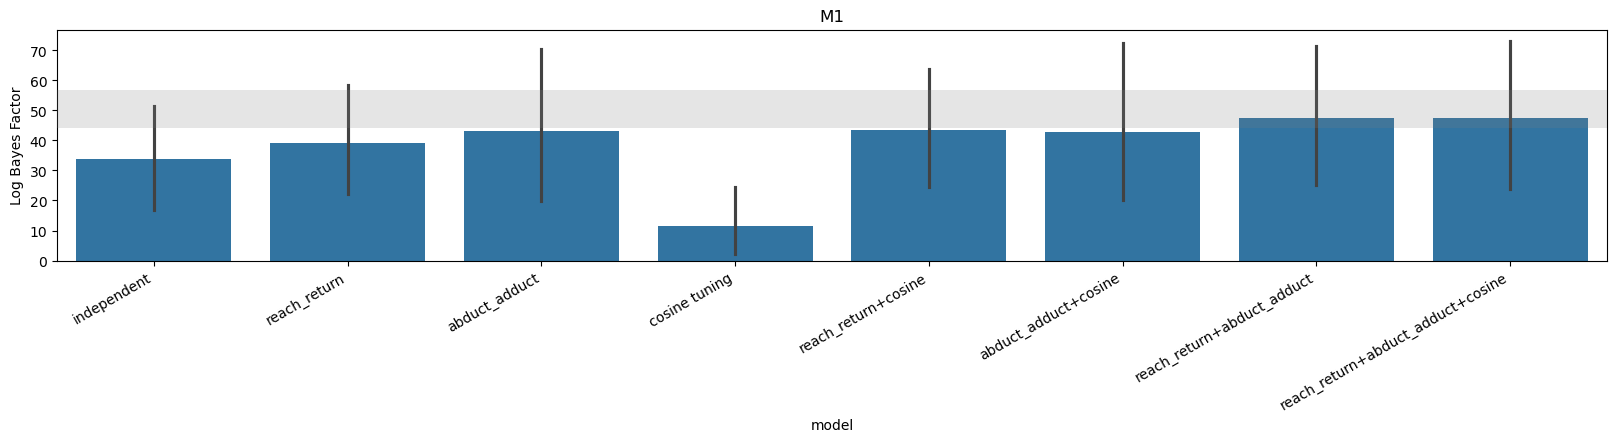

In [9]:
# T_in, theta_in = pcm.fit_model_individ(Y, M, fit_scale=True, fixed_effect='block', verbose=False)
T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

# save the results:
import pickle
results = {
           'T_gr': T_gr, 'theta_gr': theta_gr,
           'T_cv': T_cv, 'theta_cv': theta_cv
           }
with open(os.path.join(analysisDir, f'PCM_direction_encoding_{region}.pkl'), 'wb') as f:
    pickle.dump(results, f)

fig, ax = plt.subplots(1,1, figsize=(10,3))
ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil',
                        upper_ceiling = T_gr.likelihood['ceil'])
# ax.set_ylim(-300, 150)
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
plt.show()



# Fit all regions

Processing region: M1
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group model 9
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8
Fitting group cross model 9


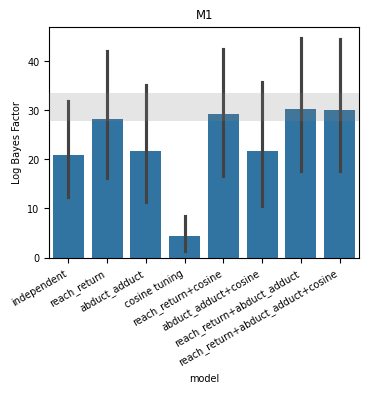

Processing region: S1
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group model 9
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8
Fitting group cross model 9


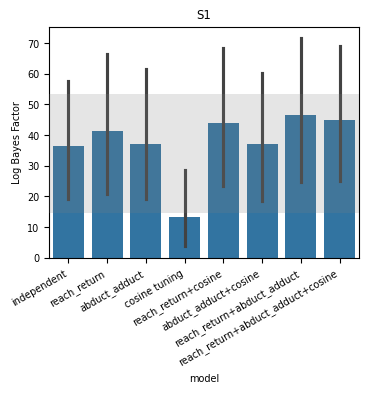

Processing region: PMd
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group model 9
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8
Fitting group cross model 9


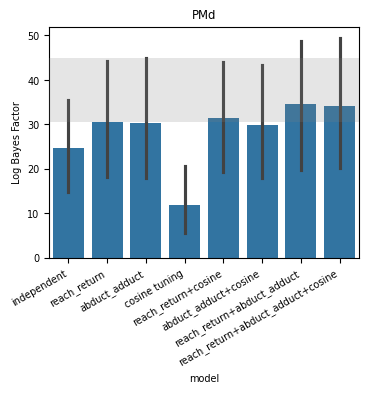

Processing region: PMv
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group model 9
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8
Fitting group cross model 9


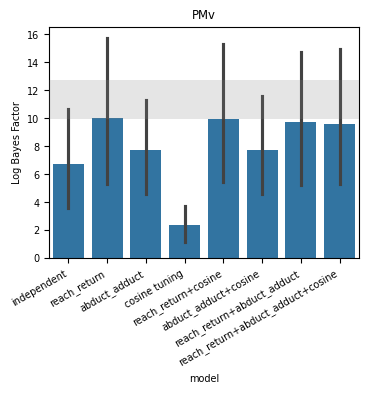

Processing region: SMA
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group model 9
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8
Fitting group cross model 9


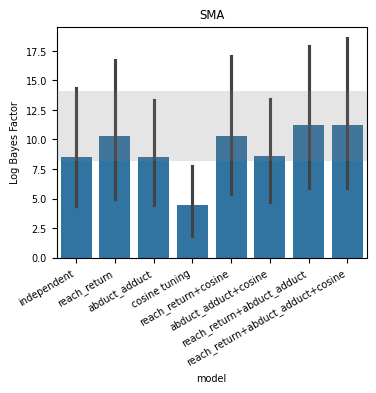

Processing region: SPLa
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group model 9
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8
Fitting group cross model 9


In [ ]:
regions = ['M1', 'S1', 'PMd', 'PMv', 'SMA', 'SPLa', 'SPLp', 'V1']
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
conditions = ['lhand','rhand','lhand','rhand']
sn_bad = [102, 103]

for region in regions:
    print(f'Processing region: {region}')
    # ============================ BUILD DATASET ============================
    rois = [f'{region}_R', f'{region}_L', f'{region}_L', f'{region}_R']
    data, cond_vec, part_vec = [], [], []
    for roi, condition in zip(rois, conditions):
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]
        
        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]
        
        for i_sub in range(len(subject)):
            # Filter for the current condition
            if condition == 'lhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that left hand goes in that direction:
                        tmp_name = f'bi:{direction}_'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'lhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'rhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that right hand goes in that direction:
                        tmp_name = f'_{direction}'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'rhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'lhand' or condition == 'rhand':
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- RDM Calculation ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    # ============================ BUILD Models ============================
    ncond = 6
    M = []
    modelG = {}

    # Null model - no information:
    cov = np.zeros((ncond, ncond))
    M_null = pcm.model.FixedModel('null', cov)
    M.append(M_null)

    # indepdent model
    cov = np.eye(ncond)
    cov = cov/np.trace(np.eye(ncond))
    M_indep = pcm.model.FixedModel('independent', cov)
    M.append(M_indep)

    # reach and return model:
    covs = np.tile(np.eye(ncond//2), (2,2))
    covs = covs / np.trace(covs)
    M_reach_return = pcm.model.FixedModel('reach_return', covs)
    M.append(M_reach_return)
    modelG['reach_return'] = [covs]

    # Mirror Along vertical axis:
    covs = np.eye(ncond)
    covs[0,3] = 1
    covs[1,2] = 1
    covs[2,1] = 1
    covs[3,0] = 1
    covs[4,5] = 1
    covs[5,4] = 1
    covs = covs / np.trace(covs)
    M_abduct_adduct = pcm.model.FixedModel('abduct_adduct', covs)
    M.append(M_abduct_adduct)
    modelG['abduct_adduct'] = [covs]

    # Cosine tuning curve model:
    angles_deg = np.array([0, 60, 120, 180, 240, 300], dtype=float)
    delta = np.deg2rad(angles_deg[:, None] - angles_deg[None, :])
    corr = np.cos(delta)        # Correlation: normalized to unit variance
    corr = corr / np.trace(corr)
    M_cosine = pcm.model.FixedModel('cosine tuning', corr)
    M.append(M_cosine)
    modelG['cosine tuning'] = [corr]

    # Component model: reach_return + cosine:
    M_rr_cos = pcm.ComponentModel('reach_return+cosine',[modelG['reach_return'][0],modelG['cosine tuning'][0]])
    M.append(M_rr_cos)

    # Component model: abduct_adduct + cosine:
    M_abduct_adduct_cos = pcm.ComponentModel('abduct_adduct+cosine',[modelG['abduct_adduct'][0],modelG['cosine tuning'][0]])
    M.append(M_abduct_adduct_cos)

    # Component model: reach_return + abduct_adduct:
    M_rr_abduct_adduct = pcm.ComponentModel('reach_return+abduct_adduct',[modelG['reach_return'][0],modelG['abduct_adduct'][0]])
    M.append(M_rr_abduct_adduct)

    # Component model: reach_return + abduct_adduct + cosine:
    M_rr_abduct_adduct_cos = pcm.ComponentModel('reach_return+abduct_adduct+cosine',[modelG['reach_return'][0],modelG['abduct_adduct'][0],modelG['cosine tuning'][0]])
    M.append(M_rr_abduct_adduct_cos)

    # noise ceiling model:
    M_ceil = pcm.model.FreeModel('ceil',ncond)
    M.append(M_ceil)


    # ============================ FIT PCM ============================
    # T_in, theta_in = pcm.fit_model_individ(Y, M, fit_scale=True, fixed_effect='block', verbose=False)
    T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)
    T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

    # save the results:
    import pickle
    results = {
            'T_gr': T_gr, 'theta_gr': theta_gr,
            'T_cv': T_cv, 'theta_cv': theta_cv
            }
    with open(os.path.join(analysisDir, f'PCM_direction_encoding_{region}.pkl'), 'wb') as f:
        pickle.dump(results, f)

    fig, ax = plt.subplots(1,1, figsize=(4,3))
    ax = pcm.model_plot(T_cv.likelihood,
                            null_model = 'null',
                            noise_ceiling= 'ceil',
                            upper_ceiling = T_gr.likelihood['ceil'])
    # ax.set_ylim(-300, 150)
    plt.xticks(rotation=30, ha='right')
    plt.title(f'{region}')
    plt.show()





# Plot

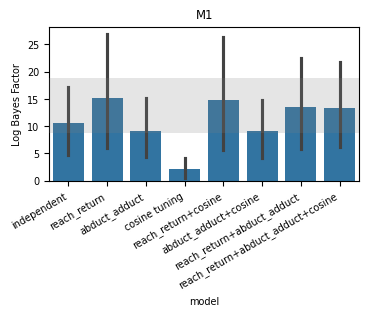

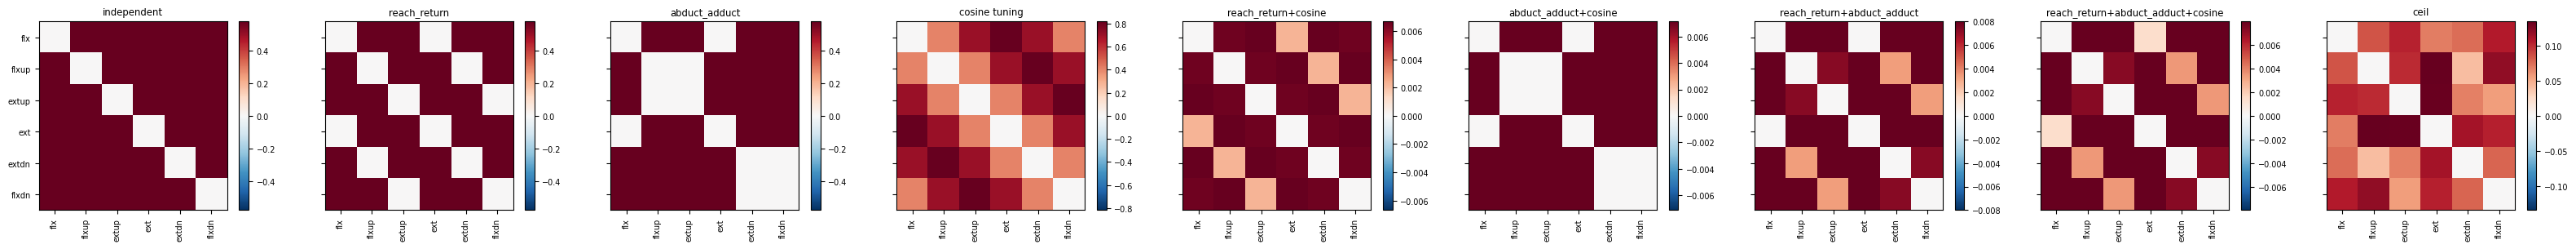

In [ ]:
import pickle

region = 'S1'
# load model fitting:
with open(os.path.join(analysisDir, f'PCM_direction_encoding_{region}.pkl'), 'rb') as f:
    results = pickle.load(f)
T_gr = results['T_gr']
theta_gr = results['theta_gr']
T_cv = results['T_cv']
theta_cv = results['theta_cv']

# font size:
plt.rcParams.update({'font.size': 7})
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil',
                        upper_ceiling = T_gr.likelihood['ceil'])
# angle the x axis labels:
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
# ax.set_ylim(-300, 150)
plt.show()

# load model fitting:
with open(os.path.join(analysisDir, f'PCM_direction_encoding_{region}.pkl'), 'rb') as f:
    results = pickle.load(f)
T_gr = results['T_gr']
theta_gr = results['theta_gr']
T_cv = results['T_cv']
theta_cv = results['theta_cv']

fig, ax = plt.subplots(1,nmodels-1, figsize=(40,3), sharey=True)
for i in range(1,nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i-1].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i-1].set_title(M[i].name)
    ax[i-1].set_xticks([0,1,2,3,4,5])
    ax[i-1].set_xticklabels(labels, rotation=90)
    ax[i-1].set_yticks([0,1,2,3,4,5])
    ax[i-1].set_yticklabels(labels)
    plt.colorbar(ax[i-1].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i-1])
plt.show()




# T-Test

In [18]:
# load model fits:
import pickle
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'
name = f'{region}'
# load model fitting:
with open(os.path.join(analysisDir, f'PCM_direction_encoding_{name}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)
T_cv = results['T_cv']
theta_cv = results['theta_cv']

# T-test between models:
from scipy import stats
likelihood = T_cv.likelihood
m_names = likelihood.columns.values
baseline = likelihood.loc[:,'null'].values
likelihood = likelihood - baseline.reshape(-1,1)

bayesfact = {'independent': [], 'ReachReturn': [], 'AbductAdduct': [], 'cosine': [],
            'ReachReturn+AbductAdduct': [], 'ReachReturn+cosine': [], 'AbductAdduct+cosine': [], 'ReachReturn+AbductAdduct+cosine': []}
bayesfact['independent'] = likelihood.loc[:,'independent'].values
bayesfact['ReachReturn'] = likelihood.loc[:,'reach_return'].values
bayesfact['AbductAdduct'] = likelihood.loc[:,'abduct_adduct'].values
bayesfact['cosine'] = likelihood.loc[:,'cosine tuning'].values
bayesfact['ReachReturn+AbductAdduct'] = likelihood.loc[:,'reach_return+abduct_adduct'].values
bayesfact['ReachReturn+cosine'] = likelihood.loc[:,'reach_return+cosine'].values
bayesfact['AbductAdduct+cosine'] = likelihood.loc[:,'abduct_adduct+cosine'].values
bayesfact['ReachReturn+AbductAdduct+cosine'] = likelihood.loc[:,'reach_return+abduct_adduct+cosine'].values

# ttest each model >0:
ttests = {}
for k in bayesfact.keys():
    t, p = stats.ttest_1samp(bayesfact[k], 0, alternative='greater')
    mean = np.mean(bayesfact[k])
    std = np.std(bayesfact[k])
    sem = stats.sem(bayesfact[k])
    ttests[k] = {'t': t, 'p': p, 'dof': len(bayesfact[k])-1, 'mean': mean, 'std': std, 'sem': sem}
    print(f'{k}: t({ttests[k]["dof"]})={t:.2f}, p={p:.4f}, mean={mean:.2f} std={std:.2f} sem={sem:.2f}')

# Model comparisons:
t, p = stats.ttest_rel(bayesfact['ReachReturn'], bayesfact['independent'], alternative='greater')
mean_diff = np.mean(bayesfact['ReachReturn'] - bayesfact['independent'])
std_diff = np.std(bayesfact['ReachReturn'] - bayesfact['independent'])
sem_diff = stats.sem(bayesfact['ReachReturn'] - bayesfact['independent'])
dof = len(bayesfact['ReachReturn']) - 1
print('\nModel comparison:')
print(f'Paired t-test ReachReturn > Independent: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

t, p = stats.ttest_rel(bayesfact['AbductAdduct'], bayesfact['independent'], alternative='greater')
mean_diff = np.mean(bayesfact['AbductAdduct'] - bayesfact['independent'])
std_diff = np.std(bayesfact['AbductAdduct'] - bayesfact['independent'])
sem_diff = stats.sem(bayesfact['AbductAdduct'] - bayesfact['independent'])
dof = len(bayesfact['AbductAdduct']) - 1
print('\nModel comparison:')
print(f'Paired t-test AbductAdduct > Independent: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

t, p = stats.ttest_rel(bayesfact['ReachReturn+AbductAdduct'], bayesfact['independent'], alternative='greater')
mean_diff = np.mean(bayesfact['ReachReturn+AbductAdduct'] - bayesfact['independent'])
std_diff = np.std(bayesfact['ReachReturn+AbductAdduct'] - bayesfact['independent'])
sem_diff = stats.sem(bayesfact['ReachReturn+AbductAdduct'] - bayesfact['independent'])
dof = len(bayesfact['ReachReturn+AbductAdduct']) - 1
print('\nModel comparison:')
print(f'Paired t-test ReachReturn+AbductAdduct > Independent: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

t, p = stats.ttest_rel(bayesfact['ReachReturn+cosine'], bayesfact['independent'], alternative='greater')
mean_diff = np.mean(bayesfact['ReachReturn+cosine'] - bayesfact['independent'])
std_diff = np.std(bayesfact['ReachReturn+cosine'] - bayesfact['independent'])
sem_diff = stats.sem(bayesfact['ReachReturn+cosine'] - bayesfact['independent'])
dof = len(bayesfact['ReachReturn+cosine']) - 1
print('\nModel comparison:')
print(f'Paired t-test ReachReturn+cosine > Independent: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')



independent: t(23)=3.06, p=0.0027, mean=10.60 std=16.59 sem=3.46
ReachReturn: t(23)=2.59, p=0.0081, mean=15.25 std=28.19 sem=5.88
AbductAdduct: t(23)=3.20, p=0.0020, mean=9.16 std=13.73 sem=2.86
cosine: t(23)=2.20, p=0.0191, mean=2.04 std=4.45 sem=0.93
ReachReturn+AbductAdduct: t(23)=3.12, p=0.0024, mean=13.53 std=20.77 sem=4.33
ReachReturn+cosine: t(23)=2.71, p=0.0062, mean=14.85 std=26.23 sem=5.47
AbductAdduct+cosine: t(23)=3.22, p=0.0019, mean=9.19 std=13.69 sem=2.85
ReachReturn+AbductAdduct+cosine: t(23)=3.12, p=0.0024, mean=13.39 std=20.58 sem=4.29

Model comparison:
Paired t-test ReachReturn > Independent: t(23)=1.19, p=0.1233, mean_diff=4.65 std_diff=18.77 sem_diff=3.91

Model comparison:
Paired t-test AbductAdduct > Independent: t(23)=-0.69, p=0.7519, mean_diff=-1.43 std_diff=9.95 sem_diff=2.07

Model comparison:
Paired t-test ReachReturn+AbductAdduct > Independent: t(23)=1.35, p=0.0954, mean_diff=2.93 std_diff=10.42 sem_diff=2.17

Model comparison:
Paired t-test ReachReturn+co

# Fit noise ceiling model

In [6]:
regions = ['M1', 'S1', 'PMd', 'PMv', 'SMA', 'SPLa', 'SPLp', 'V1']
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
conditions = ['lhand','rhand']
lateral = 'ipsi'

sn_bad = [102, 103]

for region in regions:
    print(f'Processing region: {region}')
    # ============================ BUILD DATASET ============================
    rois = [f'{region}_L', f'{region}_R']
    data, cond_vec, part_vec = [], [], []
    for roi, condition in zip(rois, conditions):
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]
        
        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]
        
        for i_sub in range(len(subject)):
            # Filter for the current condition
            if condition == 'lhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that left hand goes in that direction:
                        tmp_name = f'bi:{direction}_'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'lhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'rhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that right hand goes in that direction:
                        tmp_name = f'_{direction}'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'rhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'lhand' or condition == 'rhand':
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- RDM Calculation ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    # ============================ BUILD Models ============================
    # noise ceiling model:
    M = []
    ncond = 6
    M_ceil = pcm.model.FreeModel('ceil',ncond)
    M.append(M_ceil)


    # ============================ FIT PCM ============================
    # T_in, theta_in = pcm.fit_model_individ(Y, M, fit_scale=True, fixed_effect='block', verbose=False)
    # T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)
    T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

    # save the results:
    import pickle
    results = {
            'T_cv': T_cv, 'theta_cv': theta_cv
            }
    with open(os.path.join(analysisDir, f'PCM_uni{lateral}_CVceiling_{region}.pkl'), 'wb') as f:
        pickle.dump(results, f)



Processing region: M1
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: S1
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: PMd
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: PMv
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: SMA
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: SPLa
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: SPLp
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: V1
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr